# Queue Simulation Model using Python and the SimPy library

### Import all the libraries required

In [1]:
import os
import random
import simpy
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import Markdown

### Import data to a DataFrame

In [2]:
def importData(datasetName):
    data = pd.read_csv(datasetName,delimiter=";")
    orig_df = pd.DataFrame(data, columns=data.columns)
    return orig_df

### Create the simulation model

In [3]:
class QueueSimulation:
    def __init__(self, num_users, arrival_rate, service_rate):
        self.env = simpy.Environment()                       # Create the simulation environment
        self.server = simpy.Resource(self.env, capacity=1)   # Create the server resource with a capacity of 1 (M/M/1 model)
        self.arrival_rate = arrival_rate                     # Define the arrival rate
        self.service_rate = service_rate                     # Define the service rate
        self.num_users = num_users                           # Define the number of users
        self.time_list = []                                  # Create the list to keep track of times
    
    def run(self):
        #Loop over each user and create a new process
        for i in range(0,self.num_users,8):
            self.env.process(self.user([i,i+7]))

        #Run the simulation environment
        self.env.run()
        #Convert the list of simulation times to a DataFrama
        time_df = create_timeDF(self.time_list)
        #Compute and return average wait time
        return time_df
    
    def user(self, users_in_car):
        #Generate the service time (which will be the same for all users in the car)
        service_time = random.uniform(0.9*self.service_rate,1.1*self.service_rate)
        
        for user in users_in_car:
            #Generate the moment of arrival with POISSON DISTRIBUTION
            next_user = np.random.exponential(self.arrival_rate)
            #Wait for the user to join the queue
            yield self.env.timeout(next_user)

            #Request the server resource
            with self.server.request() as request:
                joins_queue = self.env.now
                #Wait for the server to become available
                yield request
                #The user leaves the queue and is now being attended by the server 
                leaves_queue = self.env.now
                time_in_queue = leaves_queue - joins_queue
                
                #Wait for the service to be completed
                yield self.env.timeout(service_time)
                #The user has been served and departs
                departure_time = self.env.now

            #Save all the user's simulation times for analising and plotting
            self.time_list.append([int(joins_queue),int(leaves_queue),int(time_in_queue),int(service_time),int(departure_time)])

In [4]:
def create_timeDF(time_list):
    #Convert the list of simulation times to a DataFrame
    time_df = pd.DataFrame(time_list, columns=["Join queue","Leave queue","Wait time","Service time","Departure time"])
    return time_df

### Run the simulations

In [5]:
def simulate_and_plot(orig_df, arrival_rate, service_rate):
    #Display title
    display(Markdown(f"## Simulation: n={len(orig_df.index)*len(orig_df.columns[2:])},"+
                     f" $\lambda$={arrival_rate}, $\mu$={service_rate}"))
    
    noname_df = orig_df.iloc[:,2:].copy()
    new_df = orig_df.iloc[:,:3].copy()
    
    column_groups = []
    for i in range(0,len(noname_df.columns),12):
        column_groups.append(noname_df.iloc[:, i:i+12])
    
    for group,col_name in zip(column_groups,noname_df.columns[::12]):
        new_df[col_name] = group.sum(axis=1)
    
    #Create the DataFrame where simulation times will be saved
    sim_df = pd.DataFrame()
    
    sumRuns = 0
    countRuns = 0
    wait_times = []
    
    for col in new_df.columns[2:]:
        list_col = []
        #Loop through the attractions
        for row in range(len(new_df[col])):
            #If there's no users in that attraction and hour, don't simulate
            if new_df[col][row] == 0:
                list_col.append(0)
            else:
                #If there's users, run the simulation
                sim = QueueSimulation(num_users=new_df[col][row], arrival_rate=arrival_rate, service_rate=service_rate)
                time_df = sim.run()
                
                #Compute the average waiting time of the simulations
                avg_wait_time = round(time_df["Wait time"].sum()/len(time_df.index) / 60,2)
                
                #Generate a Gantt diagram for one of the simulations
                if countRuns == 50:
                    plot_gantt(time_df,service_rate,new_df[col][row])
                
                #Save all the average wait times from each attraction for analising and plotting
                sumRuns += avg_wait_time
                list_col.append(avg_wait_time)
                countRuns += 1
            #Save all the waiting times for plotting the histogram
            wait_times.append(list(time_df["Wait time"]))
        
        sim_df[col] = list_col
        #Compute and print the average waiting time for all attractions 
        avgTime = round(sumRuns/countRuns, 2)
    
    #Add the last columns to the DataFrame that will be exported
    sim_df.insert(0,new_df.columns[1],new_df[new_df.columns[1]])
    sim_df.insert(0,new_df.columns[0],new_df[new_df.columns[0]])
    
    return sim_df, wait_times, avgTime

### Plots

In [6]:
def plot_gantt(jobs_df,mu,num_users):
    #Get the number of people waiting in queue for every instance
    list_of_values = []
    list_end = []
    for joins,leaves in zip(jobs_df["Join queue"],jobs_df["Leave queue"]):
        for value in range(joins,leaves):
            list_of_values.append(value)
    
    count_values = []
    for value in range(max(list_of_values)):
        count_values.append(list_of_values.count(value))
    
    avg_count = int(sum(count_values)/len(count_values))
    
    #Generate the figure
    fig, ax1 = plt.subplots(figsize=(16,9))
    
    #Plot the Gantt chart
    ax1.set_title(f"Ride schedule with {len(jobs_df)} people", size=20)
    ax1.set_ylabel("Person ID", color="limegreen", size=15)
    ax1.barh(
        y=jobs_df.index,
        left=jobs_df["Join queue"],
        width=jobs_df["Wait time"],
        alpha=1.0,
        color="gainsboro")
    ax1.barh(
        y=jobs_df.index,
        left=jobs_df["Leave queue"],
        width=jobs_df["Service time"],
        alpha=1.0,
        color="limegreen")
    ax1.invert_yaxis()
    ax1.grid(axis="x")
    
    ax2 = ax1.twinx()

    #Plot the number of people in queue in the same chart
    ax2.set_xlabel("Time", size=15)
    ax2.set_ylabel("Number of people in queue", color="r", size=15)
    ax2.plot([x for x in range(max(list_of_values))], count_values, color="r")
    ax2.set_ylim([0, 2*max(count_values)])
    ax2.text(0.02*ax2.get_xlim()[1], 0.1*ax2.get_ylim()[1], f"Average: {avg_count} people", size=15, color="r")
    
    fig.tight_layout()
    plt.show()

In [7]:
def plot_wait_times(data,mean_times,average_time):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(16,9))
    fig.tight_layout(pad=5.0)
    fig.suptitle("Histogram of wait times with different number of users", fontsize=20)
    
    #Get min, max and median of the list of average times
    max_index = mean_times.index(max(mean_times))
    min_index = mean_times.index(min(mean_times))
    sorted_times = sorted(mean_times)
    median = sorted_times[int(len(sorted_times)/2)]
    median_index = mean_times.index(median)
    
    #Add them to a list to plot the histogram for the three of them
    list_plots = [data[min_index],data[median_index],data[max_index]]
    
    #Plot the simulations in the previous list
    for ax,time in zip(axs.ravel(),list_plots):
        #Plot the average time
        avg_time = int(sum(time)/len(time))
        avg_time_mins = round(avg_time/60,2)
        ax.axvline(x=avg_time, color="r", linestyle="-")
        ax.set_title(f"Number of users={len(time)}", size=15)
        ax.set_xlabel("Wait time")
        ax.set_ylabel("Count")
        ax.set_xlim([0, max(data[max_index])])
        ax.hist(time,bins=[bin*10 for bin in range(int(max(data[max_index])))])
        added_len = 0.02*ax.get_xlim()[1]
        if int(avg_time_mins)==0:
            ax.text(avg_time+added_len, 0.8*ax.get_ylim()[1], f"Average = {int(avg_time_mins%1*60)} seconds", color="r", size=15)
        elif avg_time_mins==int(avg_time_mins):
            ax.text(avg_time+added_len, 0.8*ax.get_ylim()[1], f"Average = {avg_time_mins} minute(s)", color="r", size=15)
        else:
            ax.text(avg_time+added_len, 0.8*ax.get_ylim()[1], f"Average = {int(avg_time_mins)} minute(s) and {int(avg_time_mins%1*60)} seconds", color="r", size=15)
        
    plt.show()

### Export the data to an Excel file

In [8]:
def exportData(export_df,csvName):
    export_df.to_csv(csvName)
    display(Markdown(f"Data exported to file '{str(csvName)}'"))

## MAIN

Paste the file's direction as text or write ESC to abort the program: Datasets/Dataset-Halloween.csv


## Simulation: n=6000, $\lambda$=30, $\mu$=20

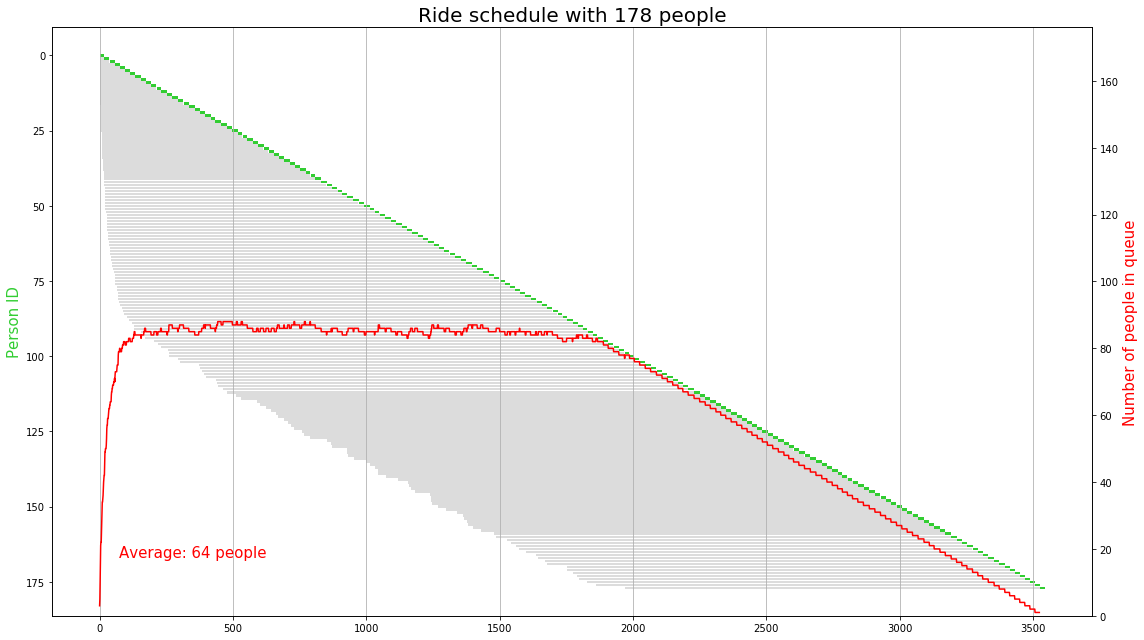

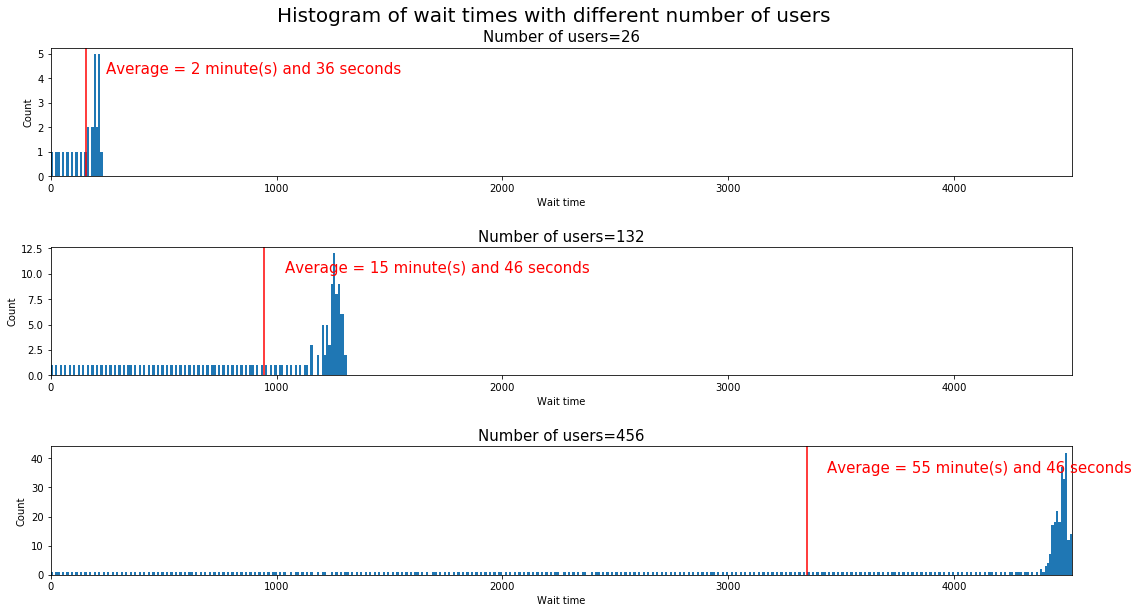

### Average wait time = 17 minute(s) and 48 seconds


Execution time = 44 seconds

Data exported to file 'wait_times_30_20.csv'

Paste the file's direction as text or write ESC to abort the program: Datasets/Dataset-Weekend.csv


## Simulation: n=6000, $\lambda$=30, $\mu$=20

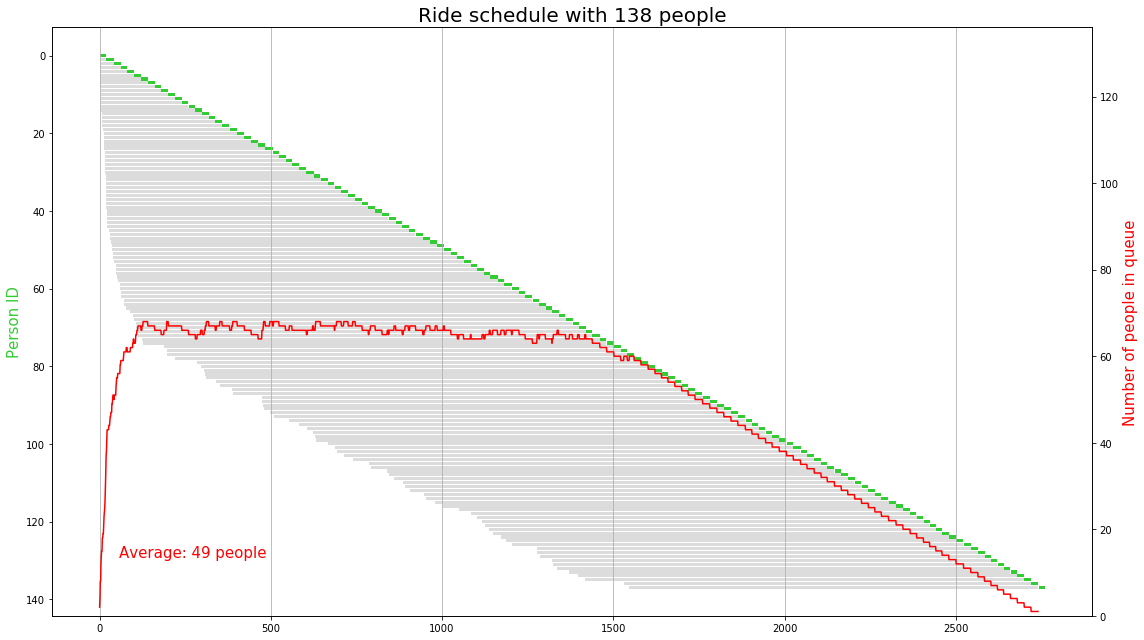

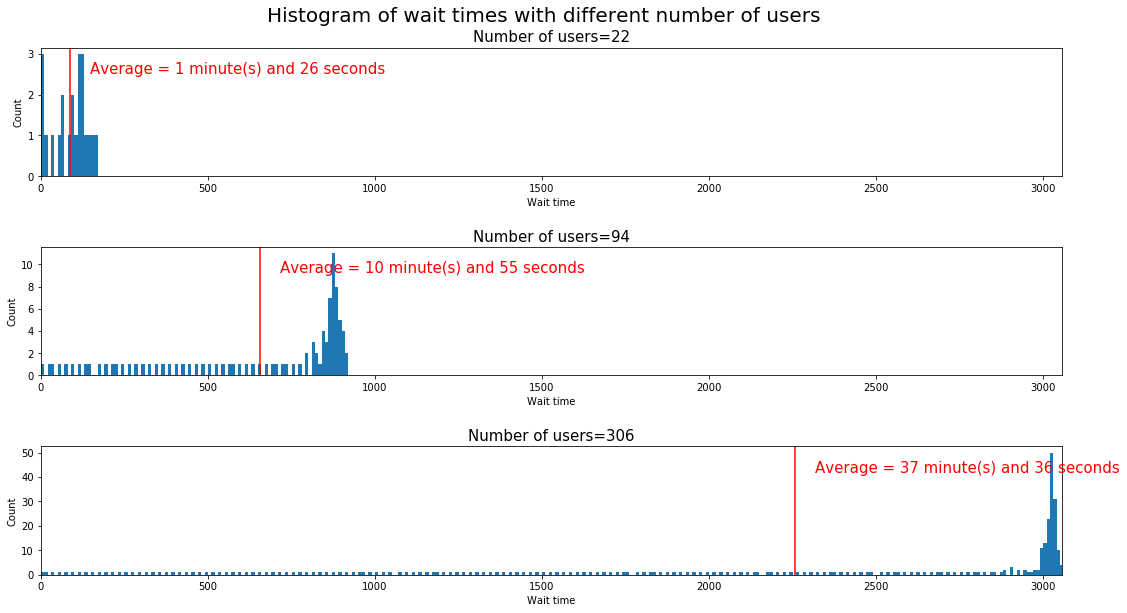

### Average wait time = 12 minute(s) and 25 seconds


Execution time = 29 seconds

Data exported to file 'wait_times_30_20.csv'

Paste the file's direction as text or write ESC to abort the program: Datasets/Dataset-Weekday.csv


## Simulation: n=6000, $\lambda$=30, $\mu$=20

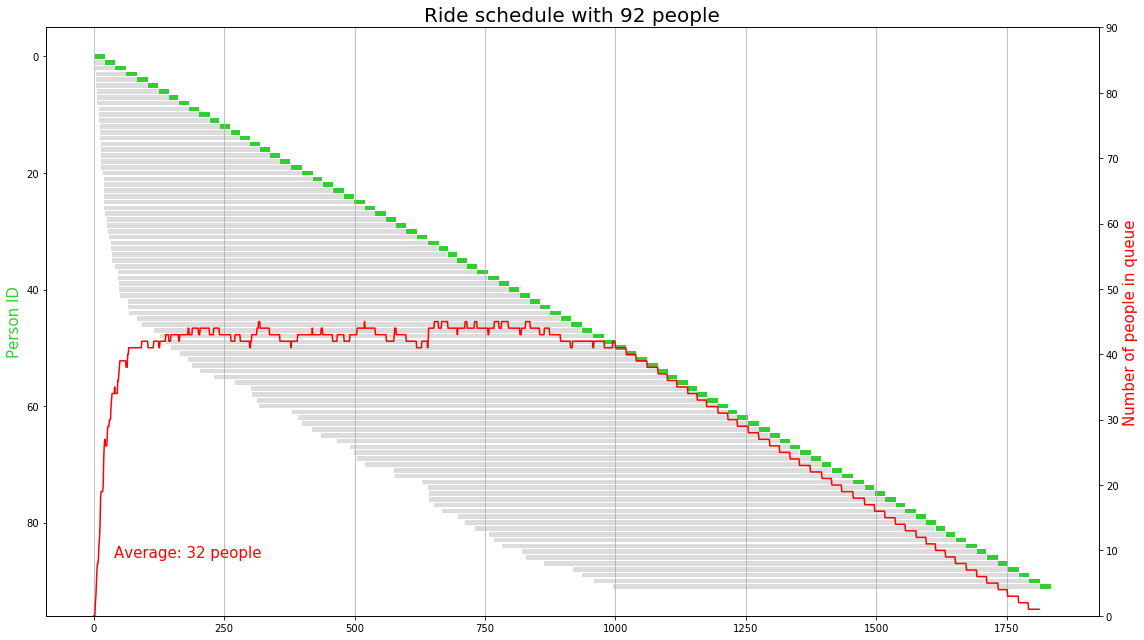

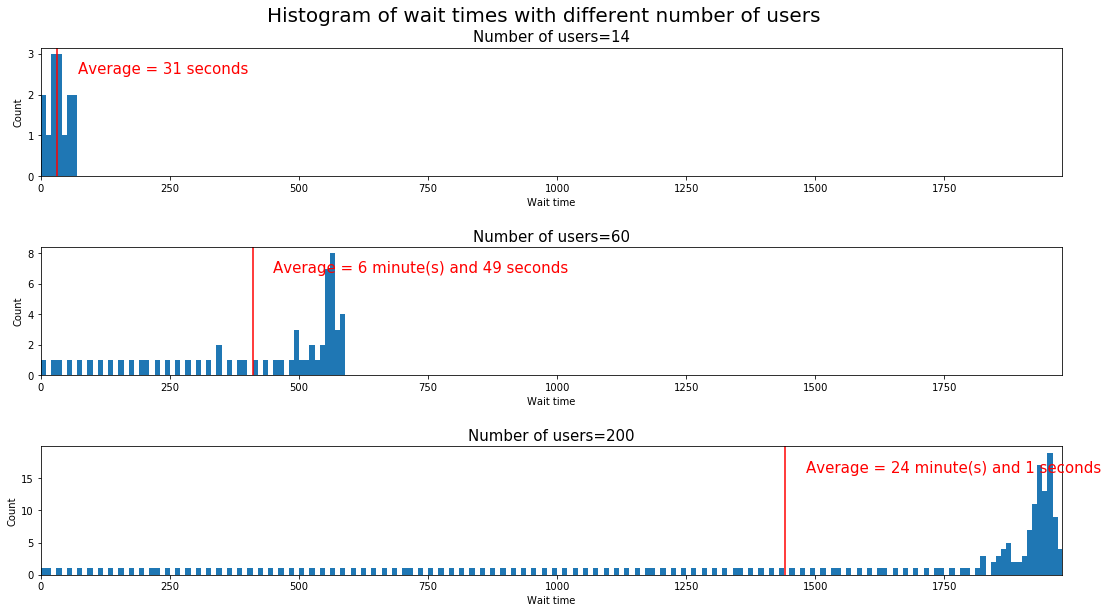

### Average wait time = 7 minute(s) and 48 seconds


Execution time = 14 seconds

Data exported to file 'wait_times_30_20.csv'

Paste the file's direction as text or write ESC to abort the program: Datasets/Dataset-Rainy.csv


## Simulation: n=6000, $\lambda$=30, $\mu$=20

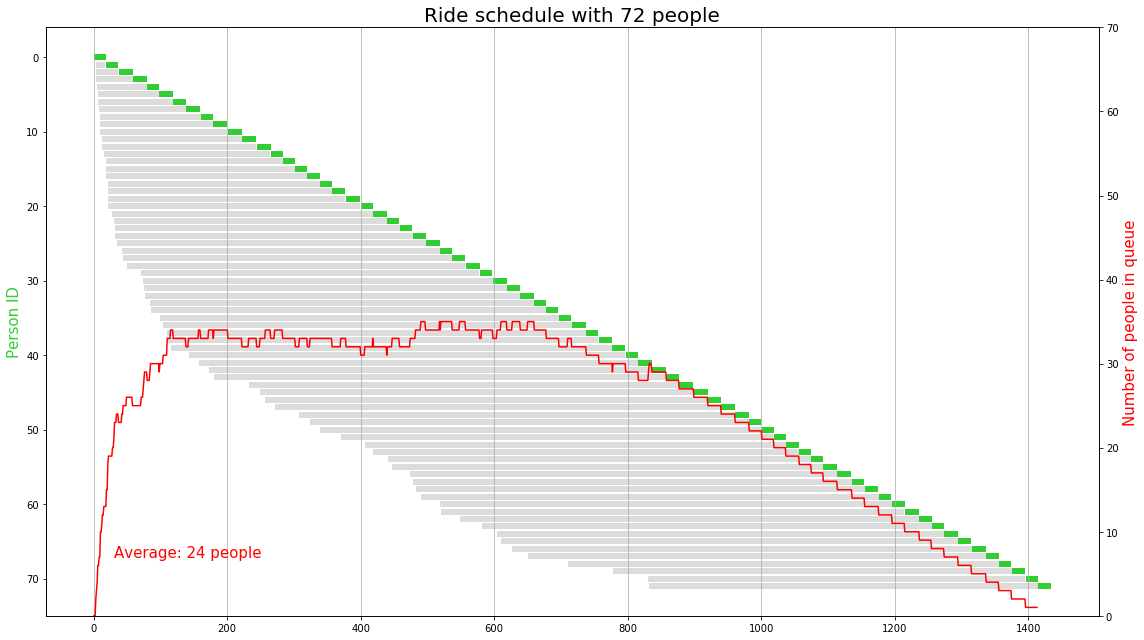

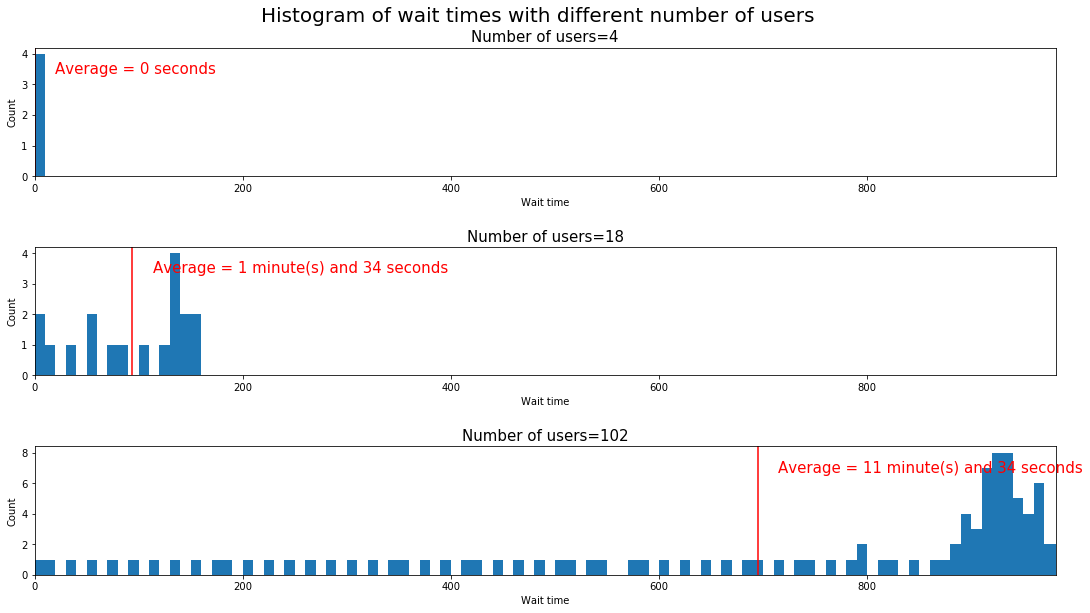

### Average wait time = 2 minute(s) and 0 seconds


Execution time = 7 seconds

Data exported to file 'wait_times_30_20.csv'

Paste the file's direction as text or write ESC to abort the program: ESC


### Program was aborted

In [9]:
#MAIN

#Parameters
arrival_rate = 30
service_rate = 20

while True:
    # Choose the file where the data is
    dataset = input("Paste the file's direction as text or write ESC to abort the program: ")
    if dataset.lower() == "esc":
        display(Markdown(f"### Program was aborted"))
        break
    
    try:
        #Import data to DF
        orig_df = importData(dataset)
            
    except Exception as e:
        print("\nERROR: There is no file or directory named "+dataset+"\n")
        continue

    start_time = time.time()
    #Run the simulations
    #sim_df, wait_time, average_time = simulate_and_plot(orig_df,arrival_rate,service_rate)
    sim_df, wait_time, average_time = simulate_and_plot(orig_df,arrival_rate,service_rate)
    
    list_means = []
    for pos,times in enumerate(wait_time):
        mean_time = round(sum(times) / len(times),2)
        list_means.append(mean_time)
    
    #Plot the wait times
    plot_wait_times(wait_time,list_means,average_time)
    stop_time = time.time()
    
    #Print average wait time
    if int(average_time)==0:
        display(Markdown(f"### Average wait time = {int(average_time%1*60)}"+" seconds"))
    elif average_time==int(average_time):
        display(Markdown(f"### Average wait time = {average_time}"+" minute(s)"))
    else:
        display(Markdown(f"### Average wait time = {int(average_time)} minute(s) and {int(average_time%1*60)} seconds"))
    
    #Print exexution time
    execution_time = stop_time-start_time
    if execution_time>60:
        display(Markdown(f"\nExecution time = {int(execution_time/60)} minute(s) and {int(execution_time%60)} seconds"))
    else:
        display(Markdown(f"\nExecution time = {int(execution_time)} seconds"))
    
    #Export data to CSV
    csvName = "wait_times_"+str(arrival_rate)+"_"+str(service_rate)+".csv"
    exportData(sim_df,csvName)


# THE FILES THAT CAN BE USED ARE:
    # Datasets/Dataset-Halloween.csv
    # Datasets/Dataset-Weekend.csv
    # Datasets/Dataset-Weekday.csv
    # Datasets/Dataset-Rainy.csv